In [9]:
#################################################################################################
# Import necessary libraries
#################################################################################################
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

from catboost import CatBoostRegressor
from ngboost.api import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost.evaluation import *


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from time import time
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

import shap
shap.initjs()

C:\Users\wlv446\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [4]:
#################################################################################################
# Import data
#################################################################################################
Data_DF = pd.read_excel("Concrete_Compressive_Strength_Dataset.xlsx")

In [5]:
#################################################################################################
# Prepare engineered features
#################################################################################################
Data_DF['W/B Ratio'] = Data_DF['Water']/(Data_DF['Cement'] + Data_DF['Blast Furnace Slag'] + Data_DF['Fly Ash'])

Data_DF['BFS/W Ratio'] = Data_DF['Blast Furnace Slag']/Data_DF['Water']

Data_DF['FA/W Ratio'] = Data_DF['Fly Ash']/Data_DF['Water']

Data_DF['CA/B Ratio'] = Data_DF['Coarse Aggregate']/(Data_DF['Cement'] + Data_DF['Blast Furnace Slag'] + Data_DF['Fly Ash'])

Data_DF['CA/FA Ratio'] = Data_DF['Coarse Aggregate']/Data_DF['Fine Aggregate']

In [4]:
df1 = Data_DF.describe()
df1.to_excel("Descriptive Statistics.xlsx")

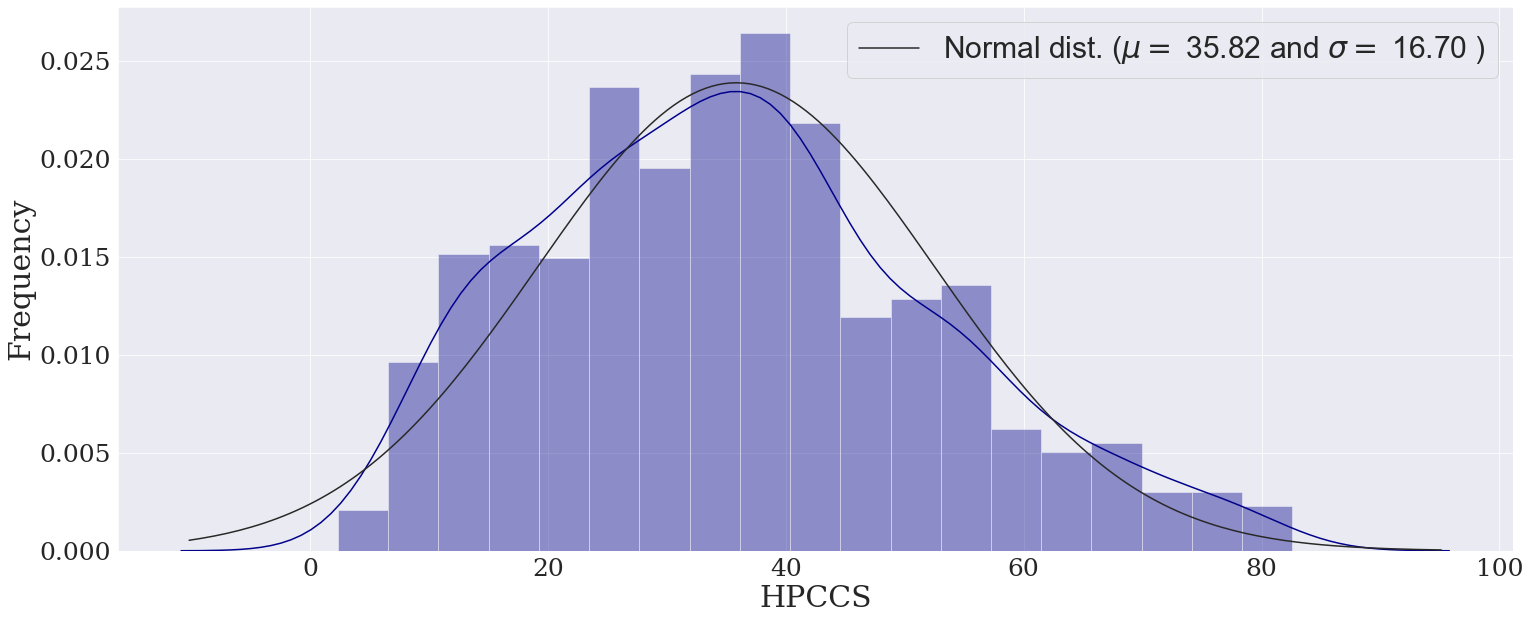

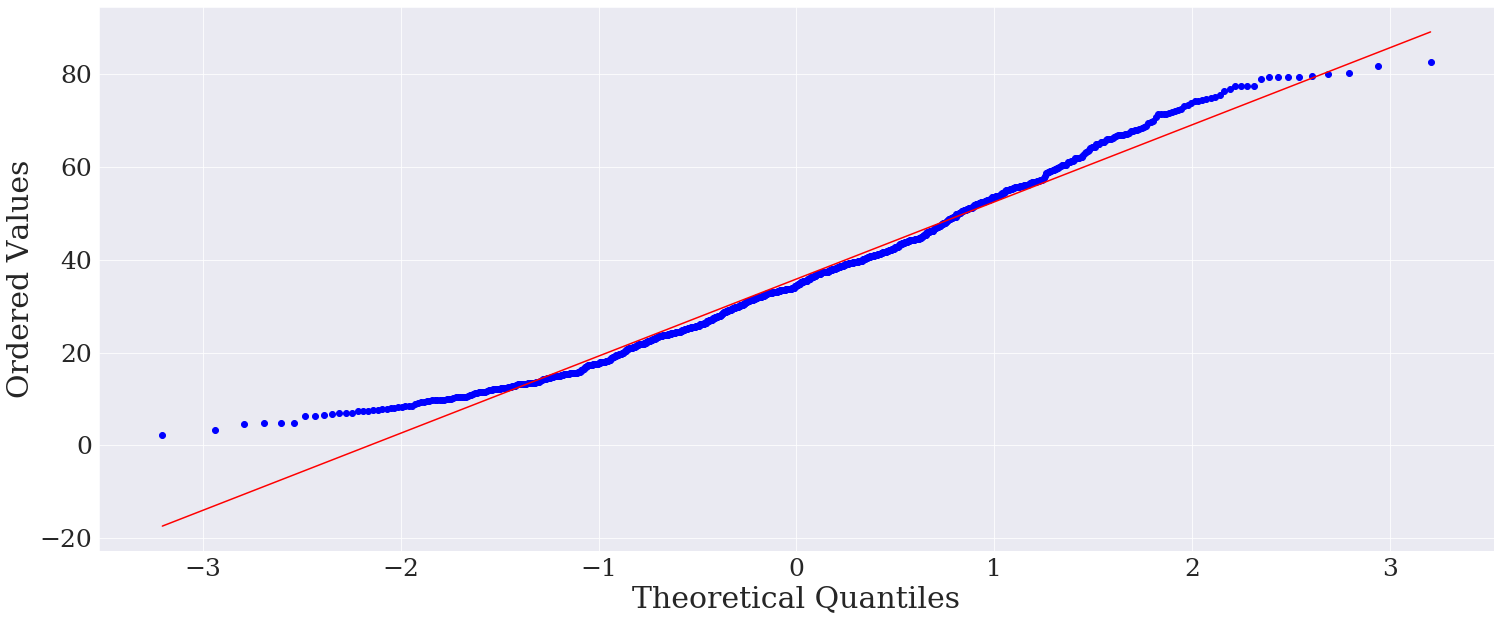

In [5]:
fig = plt.figure(figsize=(25,10),dpi=72)
sns.distplot(Data_DF['Compressive Strength'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(Data_DF['Compressive Strength'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('HPCCS', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('HPCC Distribution 1.pdf')

fig = plt.figure(figsize=(25,10),dpi=72)
res = stats.probplot(Data_DF['Compressive Strength'], plot=plt)
plt.xlabel('Theoretical Quantiles', fontsize=30, fontname='Serif')
plt.ylabel('Ordered Values', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.show
plt.savefig('HPCC Distribution 2.pdf')

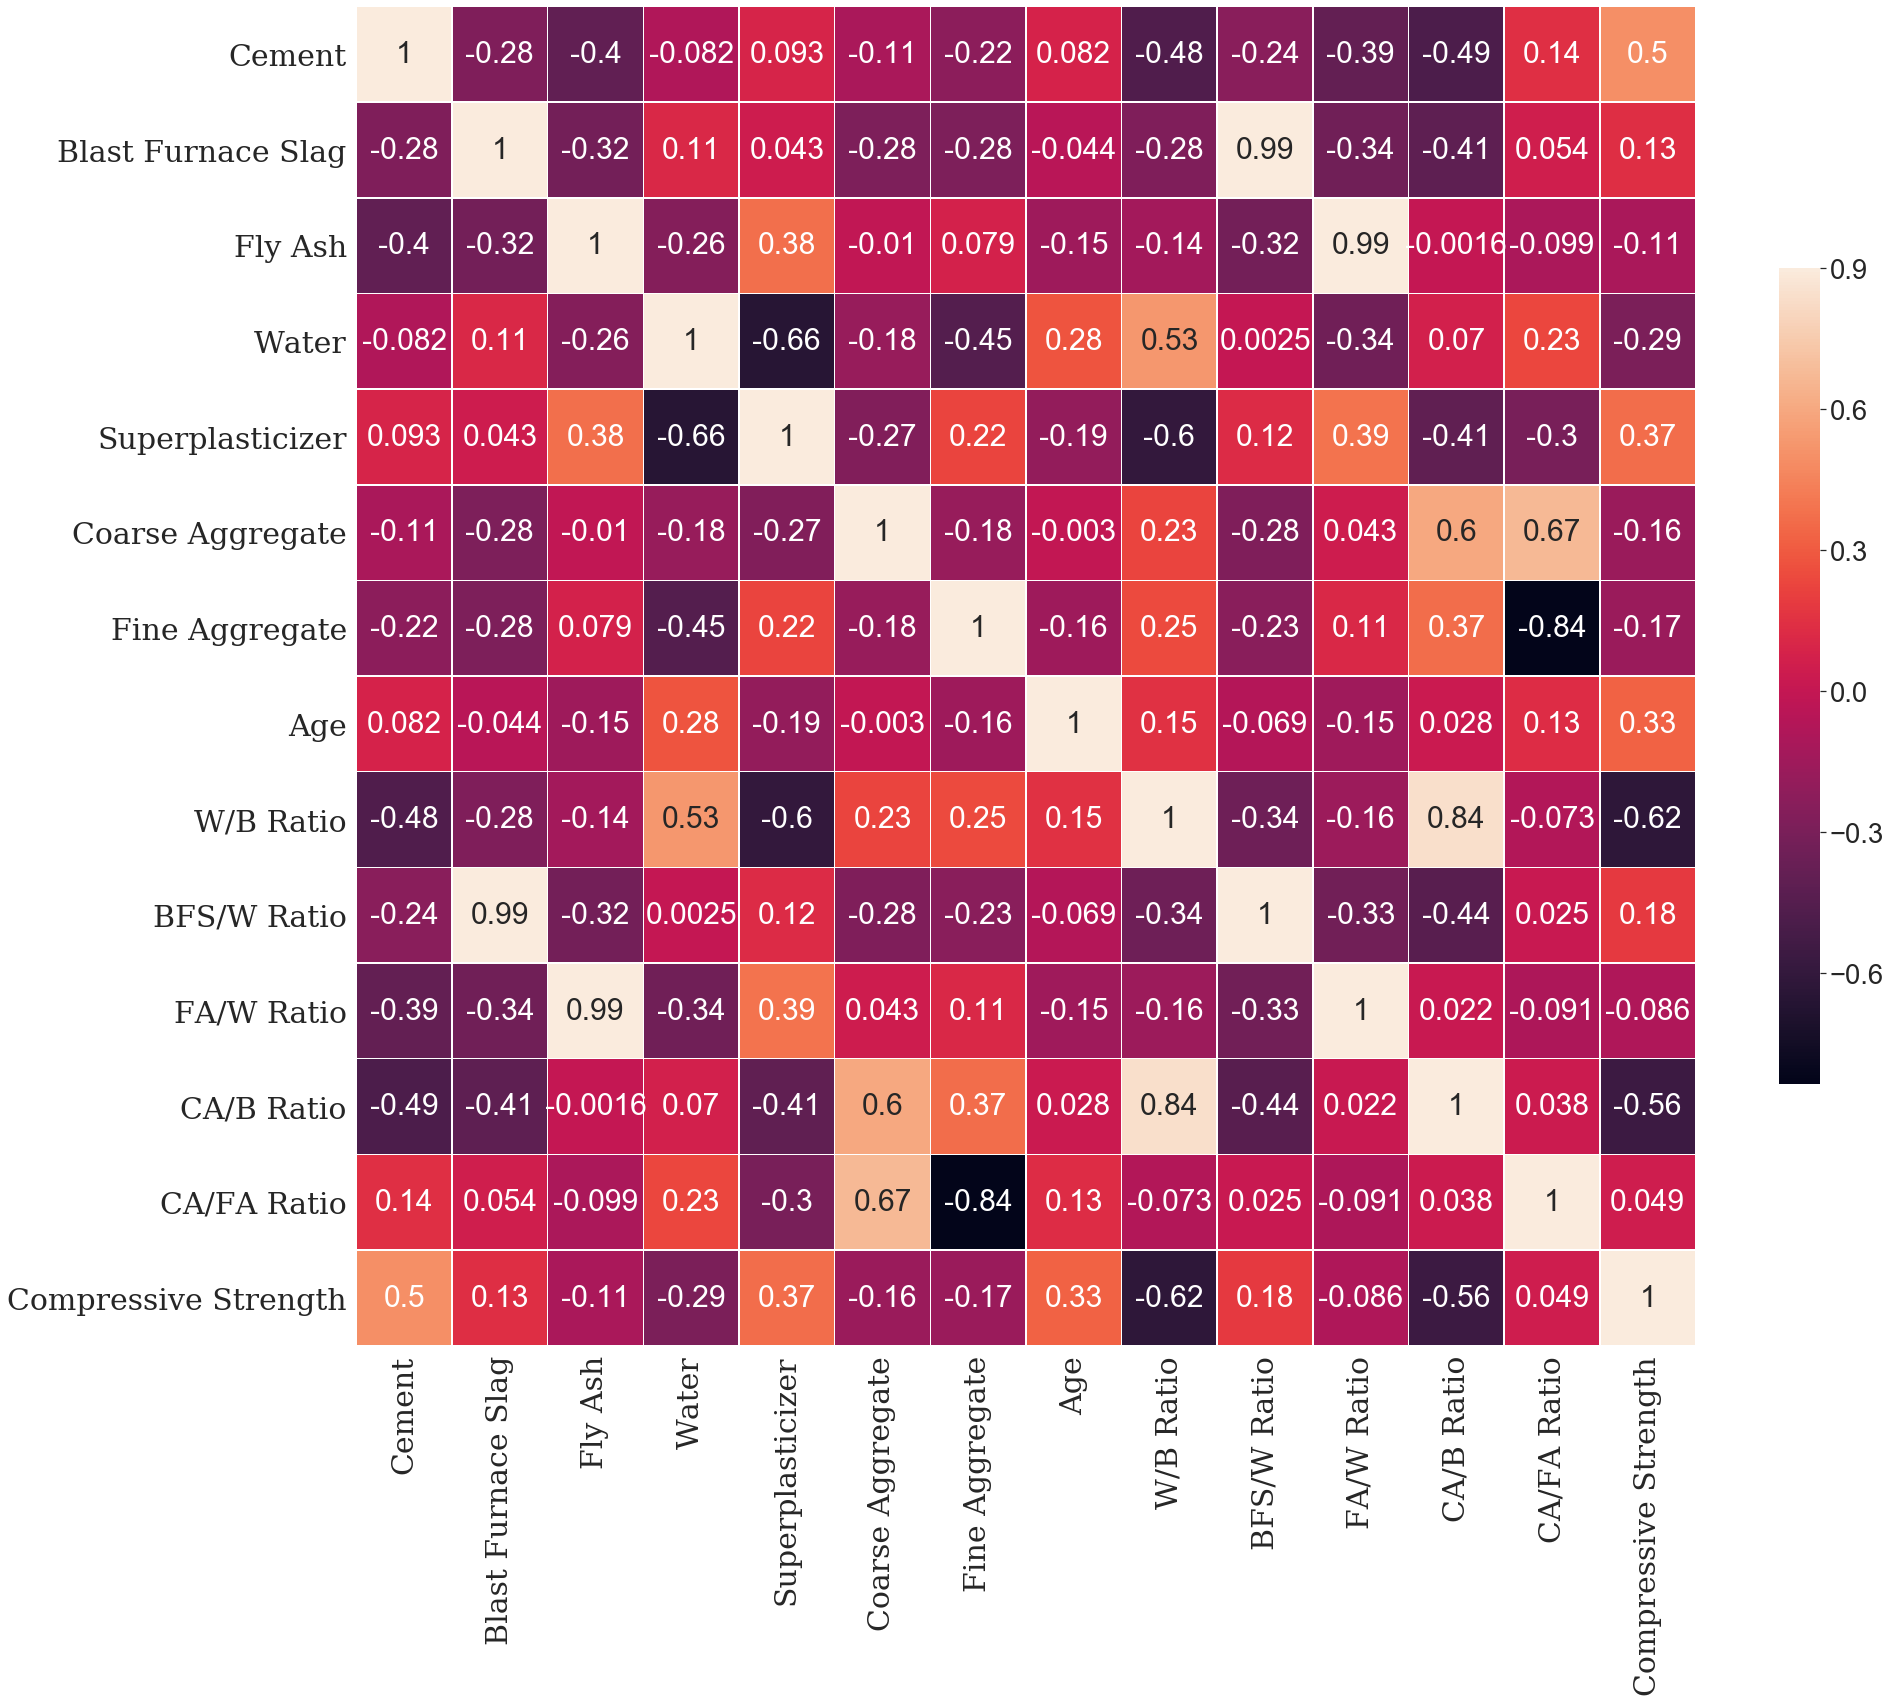

In [15]:
tmp = Data_DF['Compressive Strength']
Data_DF.drop(['Compressive Strength'], axis=1, inplace=True)
Data_DF['Compressive Strength'] = tmp

corr_mat = Data_DF.corr()
fig = plt.figure(figsize=(30,30),dpi=72)
sns.set(font_scale=2.5)
sns.heatmap(corr_mat, vmax=0.9, square=True, linewidths=.5, annot=True, annot_kws={"size": 30}, cbar_kws={"shrink": .5})
plt.xticks(fontsize=30, fontname='Serif', rotation=90)
plt.yticks(fontsize=30, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Correlation Heatmap.pdf')

In [6]:
#################################################################################################
# Create an array of features for model development
#################################################################################################
Feature_Names = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate',
                 'Age','W/B Ratio', 'BFS/W Ratio', 'FA/W Ratio', 'CA/B Ratio', 'CA/FA Ratio']

X = Data_DF[Feature_Names].to_numpy()
y = Data_DF['Compressive Strength'].to_numpy()

In [7]:
#################################################################################################
# Split data for training and testing
#################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=7)

In [9]:
#################################################################################################
# Pipeline for feature selection, hyper-parameter optimization, and model generation
#################################################################################################
t0 = time()
np.random.seed(7)
scoring_param = make_scorer(mean_squared_error,greater_is_better=False)

rfecv = RFECV(estimator=XGBRegressor(objective ='reg:squarederror'), step=1, cv=3, scoring=scoring_param)

p_grid = dict(estimator__n_estimators = [int(i) for i in np.linspace(100,7000,num=12)],
  estimator__max_depth = [int(i) for i in np.linspace(5,50,num=10)],
  estimator__learning_rate = np.linspace(0.005,0.01,num=5))

model = GridSearchCV(estimator = rfecv, param_grid = p_grid, scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

pprint(p_grid)

model.fit(X_train, y_train)

{'estimator__learning_rate': array([0.005  , 0.00625, 0.0075 , 0.00875, 0.01   ]),
 'estimator__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
 'estimator__n_estimators': [100,
                             727,
                             1354,
                             1981,
                             2609,
                             3236,
                             3863,
                             4490,
                             5118,
                             5745,
                             6372,
                             7000]}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
C:\Users\wlv446\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed: 275.4min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed: 378.0min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 390.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RFECV(cv=3,
                             estimator=XGBRegressor(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    importance_type='gain',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=3,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=100, n_jobs=1,
                                                 

In [10]:
#################################################################################################
# Make predictions on testing data and test model accuracy
#################################################################################################

Y_Test_Pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,Y_Test_Pred))
RSQ = r2_score(y_test,Y_Test_Pred)
MAPE = np.mean(np.abs((y_test - Y_Test_Pred) / y_test)) * 100
MAE = np.mean(np.abs(y_test - Y_Test_Pred))
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MAPE: %0.3f" % MAPE)
print("MAE: %0.3f" % MAE)
print("########################################")
print(" ")

############################################ Best XGBoost Model Parameters #################################
print("############ Best XGBoost Model Parameters ############")
print("Number of Estimators : %s " % model.best_params_['estimator__n_estimators'])
print("Max Depth : %s " % model.best_params_['estimator__max_depth'])
print("Learning Rate : %s " % model.best_params_['estimator__learning_rate'])
print("#######################################################")
print(" ")
############################################################################################################

############################################ Feature Importance ############################################
print("############ Feature Importance ############")
print("Original Feature Set: %s " % Feature_Names)
print(" ")
print(" ")
importance = model.best_estimator_.estimator_.get_booster().get_score(importance_type='weight')
tuples = [(k, importance[k]) for k in importance]
tuples = sorted(tuples, key=lambda s: int(s[0][1:]))
features, feature_importance = zip(*tuples)
feature_importance_data = pd.DataFrame({'Selected Features': [Feature_Names[i] for i in 
                                                              list(np.where(list(model.best_estimator_.support_))[0])],
                                        'Feature Scores': list(feature_importance)})
print(feature_importance_data.to_string(index=False))
print("############################################")
############################################################################################################

############ Model Accuracy ############
RMSE: 2.649
R-squared: 0.975
MAPE: 7.403
MAE: 1.897
########################################
 
############ Best XGBoost Model Parameters ############
Number of Estimators : 5745 
Max Depth : 5 
Learning Rate : 0.00875 
#######################################################
 
############ Feature Importance ############
Original Feature Set: ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'W/B Ratio', 'BFS/W Ratio', 'FA/W Ratio', 'CA/B Ratio', 'CA/FA Ratio'] 
 
 
  Selected Features  Feature Scores
             Cement           21877
 Blast Furnace Slag            7581
            Fly Ash            3962
              Water           10355
   Superplasticizer            8418
     Fine Aggregate            7719
                Age           34293
          W/B Ratio            7796
        BFS/W Ratio            2715
         FA/W Ratio            2290
         CA/B Ratio     

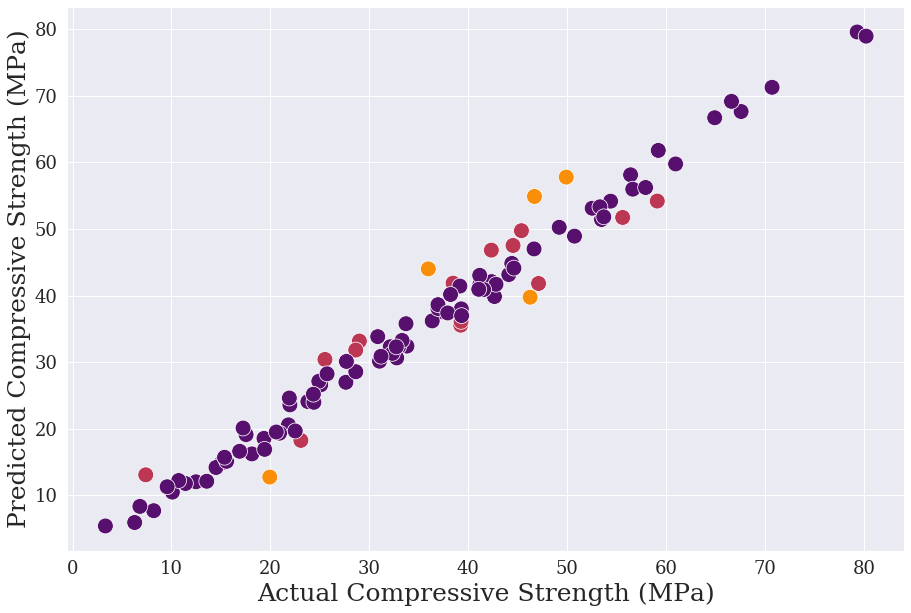

In [34]:
fig = plt.figure(figsize=(15,10),dpi=72)
#sns.set(font_scale=2.5)
my_hue = pd.cut(np.abs(y_test-Y_Test_Pred),[0,3,6,9],labels=['Min. residuals','Average residuals','Max. residuals'])
sns.scatterplot(y_test, Y_Test_Pred, color="darkgreen", s=250, hue = my_hue, palette='inferno', legend=False)
plt.xlabel("Actual Compressive Strength (MPa)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Compressive Strength (MPa)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Scatter_Plot.pdf')

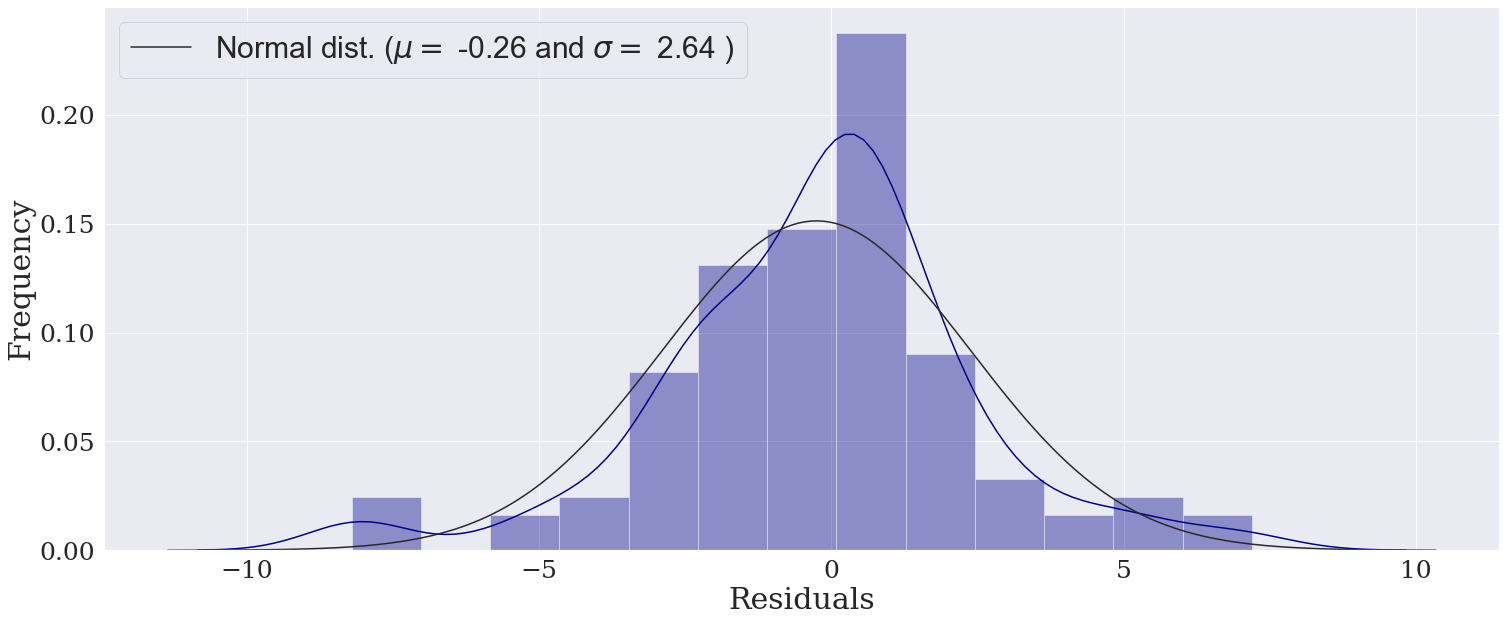

In [17]:
residuals = (y_test-Y_Test_Pred)
fig = plt.figure(figsize=(25,10),dpi=72)
sns.distplot(residuals, fit = norm, color='darkblue')
(mu, sigma) = norm.fit(residuals)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Residuals', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution.pdf')